In [1]:
%matplotlib inline
import requests
from scipy.stats import bernoulli
import pickle
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")
from itertools import product
from random import sample
from numpy.random import ranf
from collections import Counter
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
def log5(p,q):
    if p>1:
        p = p/float(100)
        q = q/float(100)
    return (p-p*q)/(p+q-2*p*q)

In [3]:
def get_stats(player, year, cutoff=None):
    if not cutoff:
        cutoff = year - 5
    if year == cutoff:
        return None
    driver = webdriver.Firefox()
    driver.maximize_window()

    wait = WebDriverWait(driver, 10)

    url = 'http://www.atpworldtour.com/en/players/foo/'+player+'/player-stats?year='+str(int(year))+'&surfaceType=clay'
    driver.get(url)
    
    print url, 

    # wait for the complete page load
    wait.until(EC.invisibility_of_element_located((By.ID, "preload")))

    # parse the HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")

    driver.close()
    try:
        _, service, return_ = soup.find_all("table")
        return [[d.get_text(strip=True) for d in i.find_all("td")] for i in service.find_all("tr")[3:6]] + [[d.get_text(strip=True) for d in i.find_all("td")] for i in return_.find_all("tr")[1:3]]
    except:
        return get_stats(l, year-1, cutoff)

In [4]:
# Randomizes seeding following the ITF rules, which can be found on page 25: http://www.itftennis.com/media/195784/195784.pdf
#
# Signature: 
# 
#   Inputs:
#     field: This is a dictionary of the form {ranking : (name, scoring_params)} and is randomized in this function
#
#   Outputs:
#     seeding: This outputs a dictionary of the form {tournament seed : ranking}

def drawOpen(field):
    final_loc = {n+1 : "" for n in range(128)}
    randomization = sample(field.keys(), len(field.keys()))
    special_locations = {1 : [1], 
                     2 : [2],
                     3 : [3,4],
                     5 : [5,6,7,8],
                     9 : [9,10,11,12],
                     13 : [13,14,15,16],
                     17 : range(17,25),
                     25 : range(25,33)}
    regular_locations = [r for r in field.keys() if not any([r in s for s in special_locations.values()])]
    temp = [s for s in sorted(special_locations.keys())]
    for r in randomization:
        if r in range(1,33):
            for i, t in enumerate(temp):
                try:
                    if t<=r and temp[i+1]>r:
                        final_loc[special_locations[t].pop()] = r
                except:
                    final_loc[special_locations[temp[-1]].pop()] = r
        else:
            final_loc[regular_locations.pop()] = r
    return final_loc

In [5]:
# Simply takes the Log5 of two teams to compute the winner.
#
# Signature: 
#
#   Inputs:
#     field:   This is a globally defined variable of the form {ranking : (name, scoring_params)}
#     p1:      an int representing the seed of a player in the field dictionary
#     p2:      same as p1
#     verbose: prints out matchup and winner
#
#   Outputs:
#     winner: The seed of the winner

def game(p1, p2, verbose=False):
    a, b = ranf(1), log5(field[p1][1], field[p2][1])
    if (a >= b):
        if verbose:
            print p1, "v", p2, "=>", p2
        return p2
    else:        
        if verbose:
            print p1, "v", p2, "=>", p1
        return p1

In [190]:
def simPoint(s, r, rev=False, verbose=False):
    res = ranf(3)
    if verbose:
        print res
    if res[0]>=s[0]:
        if res[1]>=s[0]:
#        if res[1]>=.9:
            return 0+rev
        else:
            if res[2]>=log5(s[2],r[4]):
                return 0+rev
            else:
                return 1-rev
    else:
        if res[2]>= log5(s[1],r[3]):
            return 0+rev
        else:
            return 1-rev

def simGame(players, server, verbose=False):
    s = players[1-server]
    r = players[server]
    s1, s2 = 0, 0
    winner = False
    while not winner:
        if simPoint(s, r, verbose):
            s1 += 1
        else:
            s2 += 1
        if abs(s1-s2)>=2 and max([s1,s2])>=4:
            winner = True
    if server:
        return (s1, s2)
    else:
        return (s2, s1)

def simTiebreak(players, server, verbose=False):
    if server:
        rev = False
    else:
        rev = True
    s1, s2 = 0, 0
    winner = False
    counter = 0
    while not winner:
        if counter % 2:
            rev=1-rev
        s=players[rev]
        r=players[1-rev]
        n = simPoint(s, r, rev, verbose=verbose)
        if verbose:
            print s,r,n
        if n:
            s1 += 1
        else:
            s2 += 1
        if abs(s1-s2)>=2 and max([s1,s2])>=7:
            winner = True
        counter += 1
    return (s1, s2)

def simSet(players, server, tiebreak=True, verbose=False):
    s1, s2 = 0, 0
    for i in range(12):
        w = simGame(players,server,verbose)
        if w[0]>w[1]:
            s1 += 1
        else:
            s2 += 1
        server = 1-server
        if abs(s1-s2)>=2 and max([s1,s2])>=6:
            break
    if s1+s2 == 12:
        if tiebreak:
            t = simTiebreak(players, server, verbose)
            if t[0] > t[1]:
                s1 += 1
            else:
                s2 += 1
        else:
            winner = False
            while not winner:
                w = simGame(players,server,verbose)
                if w[0]>w[1]:
                    s1 += 1
                else:
                    s2 += 1
                server = 1-server
                if abs(s1-s2)>=2:
                    winner = True
                    break                
    return (s1, s2)

def simMatch(players, server = 2, bestOf = 5, tiebreak=True, verbose=False):
    if server == 2:
        server = bernoulli.rvs(.5)        
    winCond = bestOf/2+1
    winner = False
    s1, s2 = 0, 0
    while not winner:
        res = simSet(players, server, tiebreak, verbose)
        if res[0]>res[1]:
            s1 += 1
        else:
            s2 += 1
        if verbose:
            print res
        if sum(res) % 2:
            server = 1-server
        if max(s1, s2) >= winCond:
            winner = True
    return s1>s2

In [14]:
def helper(p1, p2, verbose):
    for p in zip(test_d[p1], test_d[p2]):
        try:
            players = [zip(*player)[1] for player in p]
        except IndexError:
            pass
        except TypeError:
            players = []
            for player in p:
                try:
                    players.append(zip(*player)[1])
                except:
                    players.append(["1%"]*5)
    players = [[int(s.split("%")[0])/float(100) for s in p] for p in players]
    if simMatch(players, bestOf=5):
        return p1
    else:
        return p2

In [15]:
# Runs a single elimination tournament with no byes
#
# Signature: 
# 
#   Inputs:
#     draw:      This is a dictionary of the form {tournament seed : ranking}.  This allows for the minor randomization of
#                seeding in tennis.
#     scorefunc: The name of the function that will be used to compute who wins a matchup
#     verbose:   Print out matchup and winners
#     field:     This is required if the user wants to randomize the seeding in this function (but it is naive in randomization)
#                and is of the form {ranking : (name, scoring_params)}
#
#   Outputs:
#     winner: It outputs the winner of the tournament

def tournament(draw = None, scorefunc = game, verbose=False, field=None):
    if not draw or field:
        draw = {i+1 : v for i, v in enumerate(sample(field.keys(), len(field.keys())))}
    draw_ = draw.copy()
    playersleft = len(draw)
    rnd = 1
    while playersleft != 1:
        if verbose:
            print "Round", rnd
        n = len(draw_.values())
        draw_ = {v+1 : scorefunc(draw_[v+1], draw_[n-v], verbose) for v in range(n/2)}
        playersleft = len(draw_)
        rnd += 1
    return draw_.values().pop()

In [11]:
driver = webdriver.Firefox()
driver.maximize_window()

wait = WebDriverWait(driver, 10)

url = "http://www.rolandgarros.com/en_FR/draws/index.html?event=MS"
driver.get(url)

# wait for the complete page load
wait.until(EC.invisibility_of_element_located((By.ID, "preload")))
print "loaded page"

element = driver.find_element_by_xpath("//div[@class='navsect r1s1 match_button quarter']")
element.click()
print "clicked"

# parse the HTML
soup = BeautifulSoup(driver.page_source, "html.parser")

driver.close()

loaded page
clicked


In [12]:
players = [(i['href'].split(".html")[0][-4:], i.text) for i in soup.find_all("div", class_ = "g_round")[0].find_all("a")]
print len(players)

128


In [13]:
non_seeds = 100
players_ = []
for l, p in players:
    player = [i for i in re.split("[\[\]]", p) if i]
    if len(player) == 2:
        players_.append((player[0], int(player[1]), l))
    else:
        players_.append((player[0], non_seeds, l))
        non_seeds += 1

In [14]:
vals = list(zip(*players_)[1])
test_d2 = {}
counter = 1
while True:
    try:
        test_d2[min(vals)] = counter
        loc = np.argmin(vals)
        vals.pop(loc)
        counter += 1
    except:
        break
final_players = zip(zip(*players_)[0], tuple([test_d2[v] for v in list(zip(*players_)[1])]), zip(*players_)[2])

In [9]:
test_d = {}
for i, (p, r, l) in enumerate(final_players):
    print "\r", i, p,
    while True:
        try:
            test_d[r] = (p, l, get_stats(l, 2015))
        except:
            pass
        else:
            break

127 A. Murray  http://www.atpworldtour.com/en/players/foo/mc10/player-stats?year=2015&surfaceType=clay


In [21]:
with open('players.pickle', 'wb') as handle:
    pickle.dump(test_d, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('players2.pickle', 'wb') as handle:
    pickle.dump(final_players, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('players.pickle', 'rb') as handle:
    test_d = pickle.load(handle)

with open('players2.pickle', 'rb') as handle:
    final_players = pickle.load(handle)

In [119]:
def getLink(name):
    for t in test_d.values():
        if t[0].strip() == name:
            print "http://www.atpworldtour.com/en/players/foo/"+t[1]+'/player-stats?year=2015&surfaceType=clay'
            
def getStats(name):
    for t in test_d.values():
        if t[0].strip() == name:
            print t[2]

In [141]:
test_d[12]

(u'D. Goffin ',
 u'gb88',
 [[u'1st Serve', u'55%'],
  [u'1st Serve Points Won', u'71%'],
  [u'2nd Serve Points Won', u'53%'],
  [u'1st Serve Return Points Won', u'34%'],
  [u'2nd Serve Return Points Won', u'51%']])

In [125]:
getLink("S. Wawrinka")
getStats("S. Wawrinka")

http://www.atpworldtour.com/en/players/foo/w367/player-stats?year=2015&surfaceType=clay
[[u'1st Serve', u'55%'], [u'1st Serve Points Won', u'76%'], [u'2nd Serve Points Won', u'55%'], [u'1st Serve Return Points Won', u'32%'], [u'2nd Serve Return Points Won', u'52%']]


In [76]:
act_draw = {}
for i in range(1, 129):
    if i < 33:
        act_draw[i] = i
    else:
        act_draw[i] = 161-i

In [110]:
%%time

nsims = 100000
a, b = [], []
for i in range(nsims):
    print "\r", i/float(nsims),
    a.append(tournament(drawOpen(test_d), helper))
    b.append(tournament(act_draw, helper))

0.99999Wall time: 6h 12min 24s



In [136]:
%%time

nsims = 10000
c, d = [], []
for i in range(nsims):
    print "\r", i/float(nsims),
    c.append(tournament(drawOpen(test_d), helper))
    d.append(tournament(act_draw, helper))

0.9999Wall time: 42min 11s



In [185]:
%%time

nsims = 10000
field = {1 : 1,
         2 : 13,
         3 : 2,
         4 : 3}

e = []
for i in range(nsims):
    print "\r", i/float(nsims),
    e.append(tournament(draw=field, scorefunc=helper))

0.9999Wall time: 30.1 s



In [207]:
inpt = e
sm = float(sum(Counter(inpt).values()))

for i, (k, v) in enumerate(Counter(inpt).most_common()):
    print i+1, k, test_d[k][0], v/sm
    #if i == 0:
    #    break
        
#compare(e, b)

1 1 N. Djokovic  0.6115
2 2 A. Murray  0.3119
3 13 D. Thiem  0.0429
4 3 S. Wawrinka  0.0337


In [201]:
def compare(a,b):
    x = float(sum(Counter(a).values()))
    y = float(sum(Counter(b).values()))
    temp = []
    for i in range(1,129):
        a_, b_ = 0, 0
        try:
            a_ = Counter(a)[i]/x
        except:
            pass
        try:
            b_ = Counter(b)[i]/y
        except:
            pass
        if (a_-b_)/float(10000):
            if a_>b_:
                temp.append((a_-b_, test_d[i][0], True))
            else:
                temp.append((b_-a_, test_d[i][0], False))
    for i, (s, n, b) in enumerate(sorted(temp, reverse=True)):
        if b:
            print i+1, n, s
        else:
            print i+1, n, s*-1

In [9]:
# Bill James Log 5

Wall time: 1.99 s


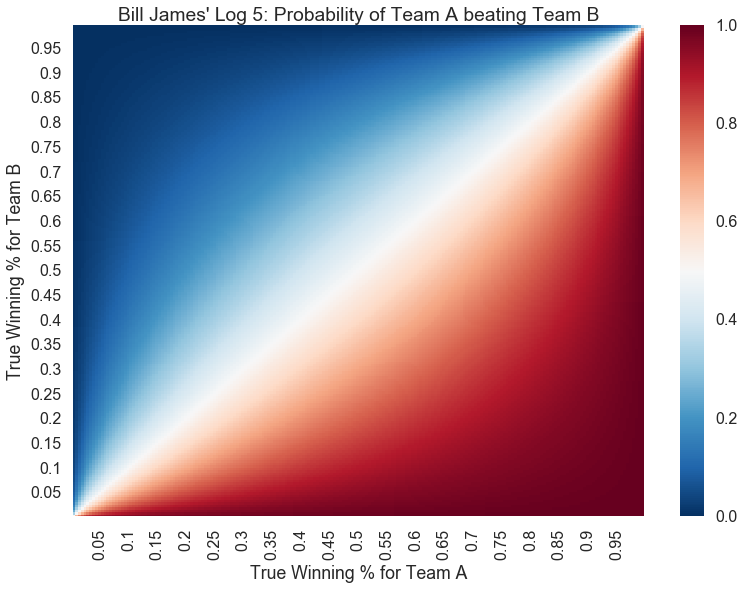

In [113]:
%%time

step = .005
min_ = step
max_ = 1

vals = np.arange(min_,max_,step)

heatmap = [[log5(v, v_) for v in vals] for v_ in reversed(vals)]

num = .05/step

test = ["" if i % num != num-1 else x for i, x in enumerate(vals)]

ax = sns.heatmap(np.array(heatmap), vmin=0, vmax=1, center=.5, xticklabels=test, yticklabels=list(reversed(test)))
ax.set_xlabel("True Winning % for Team A")
ax.set_ylabel("True Winning % for Team B")
ax.set_title("Bill James' Log 5: Probability of Team A beating Team B")
ax.set_xticklabels(test, rotation=90)
plt.savefig("Log5.png")